In [1]:
######################################################################################################
### Great title AND movie! (https://en.wikipedia.org/wiki/Inception)
###
### After a googol zoom-ins, there are only a few patterns that can show up.
### -- (1)*2         A full black(white) pattern (if there is a black(white) square in the initial grid)
### -- (C-1)*2       WB(BW) vertical walls (assuming there is a WB(BW) wall in the initial grid)
### -- (R-1)*2       WB(BW) horizontal walls (assuming there is a WB(BW) wall in the initial grid)
### -- (R-1)(C-1)*10 Corner patterns, assming the corner patern shows up in the initial grid
###
### For reference, here are the 16 patterns mentioned above
###           B W BB BB WB BW WW WW BW WB WB BW
### B W BW WB W B BW WB BB BB WB BW WW WW BW WB
###
### Note we can be sloppy and pad these out to 16 2x2 patterns, but we MUST do the checking not assuming 2x2
### BB WW BW WB BB WW BB BB WB BW WW WW BW WB WB BW
### BB WW BW WB WW BB BW WB BB BB WB BW WW WW BW WB
###
### What we can do is
### a) figure out which subset of these 16 patterns exist in the original grid.
### b) For the ones that do (16) 
###    -- Position them in the grid (say O(RC) of these)
###    --     Retain the squares in the original grid that match (O(RC))
###    --     Do a "union find" of the remaining cells with their neighbors to collect patterns (~O(RC)) -- some inverse ackerman.
###    --     Find the biggest one and set our running best as appropriate
### This appears to be around O(R^2C^2) which seem to fit comfortably in the time limits
######################################################################################################

################################################################
## BEGIN UnionFind
################################################################

mutable struct UnionFind{T}
    parent::Dict{T,T}
    size::Dict{T,Int64}
    
    UnionFind{T}() where {T} = new{T}(Dict{T,T}(),Dict{T,Int64}())
    
    function UnionFind{T}(xs::AbstractVector{T}) where {T}
        myparent = Dict{T,T}()
        mysize = Dict{T,Int64}()
        for x in xs; myparent[x] = x; mysize[x] = 1; end
        new{T}(myparent,mysize)
    end
end

function Base.push!(h::UnionFind,x) 
    ## Assume that we don't push elements on that are already in the set
    if haskey(h.parent,x); error("ERROR: Trying to push an element into UnionFind that is already present"); end
    h.parent[x]=x
    h.size[x] = 1
    return h
end

function findset(h::UnionFind,x) 
    if h.parent[x] == x; return x; end
    return h.parent[x] = findset(h,h.parent[x])
end

function getsize(h::UnionFind,x)::Int64
    a = findset(h,x)
    return h.size[a]
end

function joinset(h::UnionFind,x,y)
    a = findset(h,x)
    b = findset(h,y)
    if a != b
        (a,b) = h.size[a] < h.size[b] ? (b,a) : (a,b)
        h.parent[b] = a
        h.size[a] += h.size[b]
    end
end

################################################################
## END UnionFind
################################################################

function findpat(g::Array{Char,2},R::Int64,C::Int64,nw::Char,ne::Char,sw::Char,se::Char)::Bool
    for i in 1:R
        for j in 1:C
            if g[i,j] != nw; continue; end
            if ne != '.' && (j == C || g[i,j+1] != ne);             continue; end
            if sw != '.' && (i == R || g[i+1,j] != sw);             continue; end
            if se != '.' && (i == R || j == C || g[i+1,j+1] != se); continue; end
            return true
        end
    end
    return false
end

function check(g::Array{Char,2}, g2::Array{Char,2}, g3::Array{Char,2}, R::Int64, C::Int64, nw::Char, ne::Char, sw::Char, se::Char)::Int64
    best::Int64 = 0
    for i in 1:R
        for j in 1:C
            fill!(g2,nw)
            if i+1<=R; g2[i+1:R,1:j] .= sw; end
            if j+1<=C; g2[1:i,j+1:C] .= ne; end
            if i+1<=R && j+1<=C; g2[i+1:R,j+1:C] .= se; end
            
            g3 .= [g[x,y]==g2[x,y] ? 'x' : '.' for x in 1:R, y in 1:C]
            squares = [(x,y) for x in 1:R for y in 1:C if g3[x,y] == 'x']
            uf = UnionFind{Tuple{Int64,Int64}}(squares)

            for (x,y) in squares
                if x > 1 && g3[x-1,y] == 'x'; joinset(uf,(x,y),(x-1,y)); end
                if y > 1 && g3[x,y-1] == 'x'; joinset(uf,(x,y),(x,y-1)); end
                if x < R && g3[x+1,y] == 'x'; joinset(uf,(x,y),(x+1,y)); end
                if y < C && g3[x,y+1] == 'x'; joinset(uf,(x,y),(x,y+1)); end
            end

            for xx in squares
                best = max(best,getsize(uf,xx))
            end
        end
    end
    return best
end

function main(infn="")
    infile = (infn != "") ? open(infn,"r") : length(ARGS) > 0 ? open(ARGS[1],"r") : stdin
    tt = parse(Int64,readline(infile))
    for qq in 1:tt
        print("Case #$qq: ")
        R,C = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        g::Array{Char,2} = fill('.',R,C)
        g2::Array{Char,2} = fill('.',R,C)
        g3::Array{Char,2} = fill('.',R,C)

        for i in 1:R
            g[i,:] .= [x for x in rstrip(readline(infile))]
        end

        best = 0

        ## do the W and B
        for nw in ('W','B')
            if findpat(g,R,C,nw,'.','.','.'); best = max(best,check(g,g2,g3,R,C,nw,nw,nw,nw)); end
        end

        for (nw,ne) in [('B','W'), ('W','B')]
            if findpat(g,R,C,nw,ne,'.','.'); best = max(best,check(g,g2,g3,R,C,nw,ne,nw,ne)); end
        end

        for (nw,sw) in [('B','W'), ('W','B')]
            if findpat(g,R,C,nw,'.',sw,'.'); best = max(best,check(g,g2,g3,R,C,nw,nw,sw,sw)); end
        end

        for (nw,ne,sw,se) in [('W','W','W','B'), ('W','W','B','W'), ('W','B','W','W'), ('B','W','W','W'),
                              ('B','B','B','W'), ('B','B','W','B'), ('B','W','B','B'), ('W','B','B','B'),
                              ('B','W','W','B'), ('W','B','B','W')]
            if findpat(g,R,C,nw,ne,sw,se); best = max(best,check(g,g2,g3,R,C,nw,ne,sw,se)); end
        end

        print("$best\n")
    end
end

main (generic function with 2 methods)

In [2]:
using Profile, ProfileSVG, ProfileVega

Case #1: 8
Case #2: 5
Case #3: 1
Case #4: 4
Case #5: 8
Case #1: 118
Case #2: 92
Case #3: 177
Case #4: 175
Case #5: 118
Case #6: 157
Case #7: 114
Case #8: 195
Case #9: 170
Case #10: 140
Case #11: 86
Case #12: 104
Case #13: 122
Case #14: 99
Case #15: 144
Case #16: 133
Case #17: 136
Case #18: 120
Case #19: 76
Case #20: 132
Case #21: 168
Case #22: 125
Case #23: 124
Case #24: 105
Case #25: 124
Case #26: 115
Case #27: 139
Case #28: 152
Case #29: 95
Case #30: 170
Case #31: 113
Case #32: 123
Case #33: 136
Case #34: 147
Case #35: 151
Case #36: 157
Case #37: 108
Case #38: 113
Case #39: 114
Case #40: 97
Case #41: 160
Case #42: 162
Case #43: 175
Case #44: 93
Case #45: 136
Case #46: 116
Case #47: 138
Case #48: 118
Case #49: 160
Case #50: 150
Case #51: 101
Case #52: 87
Case #53: 104
Case #54: 125
Case #55: 114
Case #56: 128
Case #57: 138
Case #58: 168
Case #59: 102
Case #60: 140
Case #61: 104
Case #62: 149
Case #63: 168
Case #64: 90
Case #65: 152
Case #66: 180
Case #67: 121
Case #68: 108
Case #69: 1

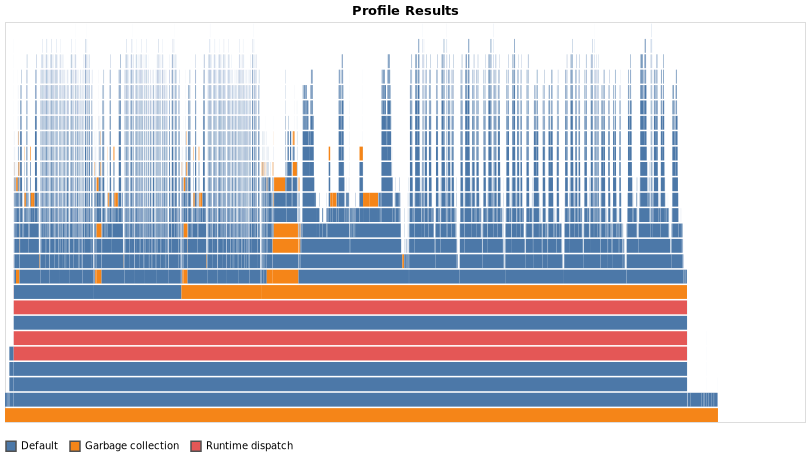

In [3]:
@profile main("/home/debr/codejams/julia/work/2018/2/D.in")
Profile.clear()
@profile main("/home/debr/codejams/julia/work/2018/2/D.in2")
ProfileVega.view()